# KV7006 Machine Learning

John Robson - W19036980 - Word Count: 2100

Importing the libaries used for the notebook

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.image import imread


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Introduction

Malaria is a life-threatening disease, which is transmitted through the bites of female Anopheles mosquitoes that are infected by a parasite called Plasmodium (Ikerionwu et al., 2022). According to Doctors Without Borders, there were an estimated 241 million cases of malaria worldwide in 2020 (Doctors Without Borders, 2021). Diagnosing malaria is performed using a rapid dipstick test or performing a blood smear test under a microscope. However, rapid dipstick tests aren’t always available, and microscopy is not always straightforward due to cells being thin and transparent (Thorn, 2016). As a result, patients are often misdiagnosed which can result in their real reasons for their symptoms going untreated or the used malarial drugs being overused and wasted.


Recently, machine learning algorithms have been developed and have proven to improve the accuracy and speed of malaria diagnosis (Liang et al., 2017; Rajaraman et al., 2018). In this report, an exploration of machine learning algorithms will be performed and a critical review of their performance in detecting malaria will be carried out.



# Methodology

## Exploratory data analysis

To develop a Machine Learning algorithm for malaria diagnosis, a suitable dataset is required for model training. The dataset used for this report is supplied by the National Library of Medicine, which contains 27,558 images of both infected and uninfected blood smear tests (Rajaraman et al., 2018). 

As robust as this dataset may be, there is always the case of potential human error in the labelling of the data, inherited from the microscope test (WHO, 2016). There may have been a decision made about ensuring this isn’t the case, and difficult-to-determine tests may have been removed, which would remove a real-world challenge from the dataset.

As a preliminary check, the dataset was read in and a random selection of the infected and uninfected images was visualised. Visual checks ensure the dataset is correctly labelled, while also reviewing the dimensions of the images. 



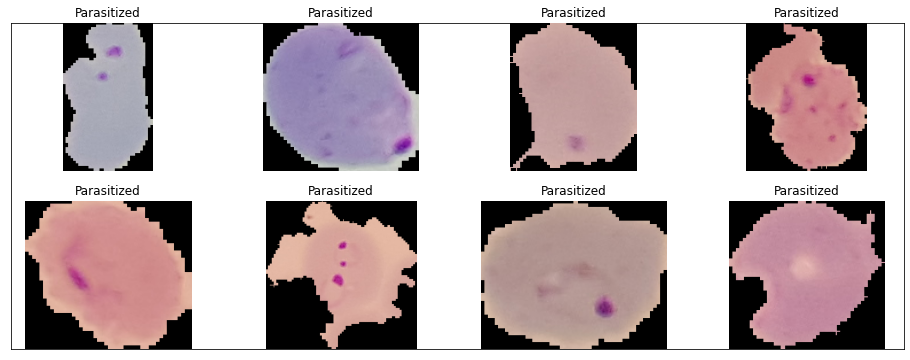

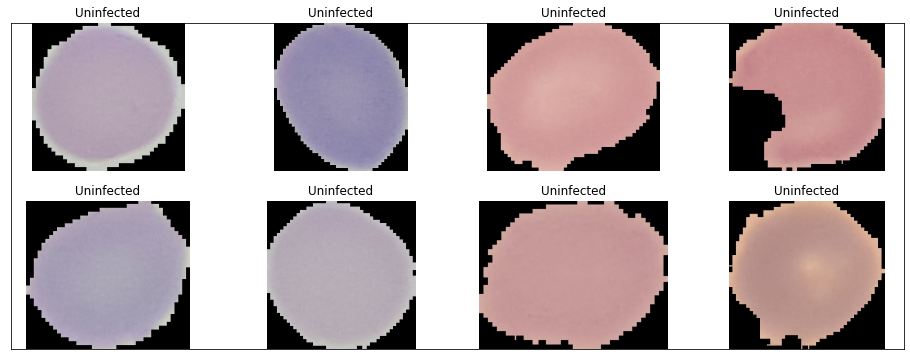

In [4]:
#Root folder
root_folder = "cell_images"
#Subclass folders
parasitized_images = [filename for filename in os.listdir(f'{root_folder}/Parasitized')]
uninfected_images = [filename for filename in os.listdir(f'{root_folder}/Uninfected')]

#Randomly get 8 images from each subclass folder
random_parasitized = np.random.choice(parasitized_images, 8, replace = False)
random_uninfected = np.random.choice(uninfected_images, 8, replace = False)

# Create new figure
figure = plt.figure(figsize=(16,6))
plt.xticks([]) , plt.yticks([])
# Add images to new figure
for i in range(8):
    filepath = f'{root_folder}/Parasitized/{random_parasitized[i]}'
    filename = image.load_img(filepath)
    ax = figure.add_subplot(2, 4, i+1)
    plt.imshow(filename)
    plt.title("Parasitized")
    plt.axis("off")  
    
# Create new figure
figure = plt.figure(figsize=(16,6))
plt.xticks([]) , plt.yticks([])
# Add images to new figure
for i in range(8):    
    filepath = f'{root_folder}/Uninfected/{random_uninfected[i-8]}'
    filename = image.load_img(filepath)
    ax = figure.add_subplot(2, 4, i+1)
    plt.imshow(filename)
    plt.title("Uninfected")
    plt.axis("off") 

The images appeared to be separated and labelled correctly after several visual tests were run on random selections, but the dimensions of the images did not match. This required some small pre-processing to be performed to resize the images to 64 x 64 pixels due to hardware limitations. A bar chart was then produced to display the total count of infected to uninfected images to ensure there was no bias to either classification. 

Distribution of Parasitized and Uninfected Images


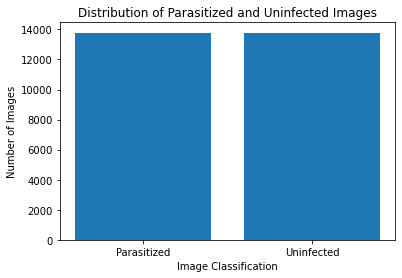

In [5]:
number_of_classes = {
    'Parasitized': len(os.listdir("cell_images/Parasitized")),
    'Uninfected': len(os.listdir("cell_images/Uninfected"))
}

plt.figure()
plt.bar(number_of_classes.keys(), number_of_classes.values())
plt.title("Distribution of Parasitized and Uninfected Images")
plt.ylabel("Number of Images")
plt.xlabel("Image Classification")

print("Distribution of Parasitized and Uninfected Images")


The dataset appears to be split perfectly 50/50 which is perfect for training a classification model, as it provides equal exposure of both classifications. An imbalanced dataset can produce a bias towards the majority class due to overfitting occurring during training, as well as the minority class becoming difficult for the model to identify due to its limited representation (Prati, Batista and Monard, 2009). 

# Pre-processing

The dataset was then split into training and testing sets, with 80% of the data used for training the model, and 20% used for testing. To remove any ordered bias not visible in the dataset, and to avoid over-exposure of 1 classification through training, the images had their order shuffled during the split. 


The dimensions of the dataset did not meet the requirements for SVM and Random Forests which require only 2 dimensions. To do this, a variable was created that held the images in greyscale, which removed the colour channel dimensions from the dataset. Finally, the data was flattened, which involved multiplying the height and width together. The data was now prepared to be fed to the SVM and Random Forest models. For the CNN, a separate dataset was read in, but the values of the colour channels were normalised by dividing their value by 255.



In [67]:
# Define file paths
data_paths = ["cell_images/Parasitized","cell_images/Uninfected"]

# Initialize X and y
X_grey = []
X_color = []
y = []

# Load the images
for path in data_paths:
    if (path == "cell_images/Parasitized"):
        label = 1
    else:
        label = 0
        
    for file_name in os.listdir(path):
        if file_name.endswith('.png'):
            # Load the image
            img = Image.open(os.path.join(path, file_name))

            # Resize and convert the image
            img = img.resize((64, 64))  # Resize to 64x64 
            img_arr = np.array(img)/255       # Convert to NumPy array
            img_arr_grey = np.array(img.convert("L"))
            
            # Append the data to X and y
            X_color.append(img_arr)
            X_grey.append(img_arr_grey)
            y.append(label)

# Convert X and y to NumPy arrays
X_color = np.array(X_color)
X_grey = np.array(X_grey)
y = np.array(y)

In [68]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_color, y, test_size=0.2, random_state=1234)
X_greytrain, X_greytest, y_greytrain, y_greytest = train_test_split(X_grey, y, test_size=0.2, random_state=1234)

In [69]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22046, 64, 64, 3)
(22046,)
(5512, 64, 64, 3)
(5512,)


In [70]:
print(X_greytrain.shape)
print(y_greytrain.shape)
print(X_greytest.shape)
print(y_greytest.shape)

(22046, 64, 64)
(22046,)
(5512, 64, 64)
(5512,)


### Flattening the dimensions of the dataset for the Random Forest and SVM model

In [10]:
# Reshaping dataset to 2 diamentins for SVM and Forest Classifiers

d1, d2, d3 = X_greytrain.shape
X_train_reshaped = X_greytrain.reshape((d1, d2*d3))


d1, d2, d3 = X_greytest.shape
X_test_reshaped = X_greytest.reshape((d1, d2*d3))


# Build, Train and Validation

## Random Forests

Random forest is an ensemble method, which fits a number of Decision Tree classifiers to sub-samples of the dataset (Korotcov et al., 2017), using averaging to provide improvements to the accuracy while controlling over-fitting. This classifier was used with a maximum depth of 6 trees, with balanced class weights.

In [11]:
rfc = RandomForestClassifier(max_depth=6, random_state=0)
rfc.fit(X_train_reshaped, y_greytrain)
forestpreds = rfc.predict(X_test_reshaped)
print(forestpreds)

[1 1 0 ... 1 0 1]


In [12]:
forestaccuracy = accuracy_score(y_greytest, forestpreds)
print("Random Forest Accuracy:", forestaccuracy)

Random Forest Accuracy: 0.7097242380261248


## Support Vector Machine

Support Vector Machine (SVM) is among the most popular algorithms used for supervised machine learning for classification problems (Chang and Lin, 2011). The learning adjustments made to the SVM’s hyperplane can be performed using different kernel functions for the decision function (Korotcov et al., 2017). 

In [13]:
clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(X_train_reshaped, y_greytrain)

svmpreds = clf.predict(X_test_reshaped)

In [14]:
svmaccuracy = accuracy_score(y_greytest, svmpreds)
print("SVM Accuracy:", svmaccuracy)

SVM Accuracy: 0.6369738751814223


Due to the way the check matrix for random forest and SVM is saved to avoid reusing training data, the developing machine struggled with memory issues. Because of this, the SGDClassifier was used to handle the loading of the data. However, data handling was not required for the CNN model, due to the model performing the training in batches of data by default, with each batch upon completion writing the new batch over it for memory cleanup.

## Convolutional Neural Network

In [73]:
first_model = Sequential()
first_model.add(Conv2D(16,(3,3),activation='relu',input_shape=(64,64,3)))
first_model.add(MaxPool2D(2,2))
first_model.add(Dropout(0.2))

first_model.add(Conv2D(32,(3,3),activation='relu'))
first_model.add(MaxPool2D(2,2))
first_model.add(Dropout(0.3))

first_model.add(Conv2D(64,(3,3),activation='relu'))
first_model.add(MaxPool2D(2,2))
first_model.add(Dropout(0.3))

first_model.add(Flatten())
first_model.add(Dense(64,activation='relu'))
first_model.add(Dropout(0.5))

first_model.add(Dense(1,activation='sigmoid'))

epochs = 3
lr = 0.001 

first_model.summary()

first_model.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 31, 31, 16)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_37 (Dropout)        (None, 14, 14, 32)       

### Performing the Training for CNN Model

In [74]:
callback = EarlyStopping(monitor='val_loss',patience=2)

print(X_train.shape)
print(y_test.shape)

history = first_model.fit(X_train, y_train, validation_data=(X_test, y_test ), epochs=epochs, batch_size=16, callbacks=[callback])

print(len(history.history['loss']))

(22046, 64, 64, 3)
(5512,)
Epoch 1/3
1378/1378 [==============================] - 21s 15ms/step - loss: 0.6903 - accuracy: 0.5342 - val_loss: 0.6772 - val_accuracy: 0.5978
Epoch 2/3
1378/1378 [==============================] - 20s 15ms/step - loss: 0.6628 - accuracy: 0.6039 - val_loss: 0.6494 - val_accuracy: 0.6241
Epoch 3/3
1378/1378 [==============================] - 20s 15ms/step - loss: 0.6365 - accuracy: 0.6563 - val_loss: 0.6047 - val_accuracy: 0.7132
3


In [75]:
print("CNN Accuracy: " + str(history.history['val_accuracy'][-1]))

CNN Accuracy: 0.7131712436676025


Once the training was complete, it was noticed that CNN was the better-performing model with an accuracy of 71.3%. Although, when compared to other work, this highlighted there may be an issue with parameters or architecture, as there are models published that are showing 97% accuracy on the same dataset (Rajaraman et al., 2018). Because of this, further work was performed on the CNN model through hyperparameter-tuning.

# Hyperparameter-tuning

For the tuning process, the same architecture was taken for the model as the previously used CNN. Tuning was applied to the first convolution layer, the dense layer before the classification layer, a variation of learning rates and a selection of optimisers being adam and sgd (Stochastic gradient descent). The tuner was then left to perform its tests, building multiple models with a variation of the parameters set to find the best-performing combination.

In [39]:
!pip install keras-tuner --upgrade

Requirement already up-to-date: keras-tuner in e:\anaconda\lib\site-packages (1.3.5)


In [40]:
import keras_tuner as kt

In [85]:
def build_model(hp):
    # Create the model
    model = Sequential()
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    
    hp_node = hp.Int('units', min_value=256, max_value=512, step=64)
    
    hp_opt = hp.Choice('optimiser',  values=['adam', 'sgd'])
    
    model.add(Conv2D(hp.Choice('filters', [8, 16]), kernel_size=(3, 3), input_shape=(64, 64, 3), activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.2))
    model.add(Conv2D(32,(3,3),activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(units = hp_node,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    if hp_opt == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif hp_opt == 'sgd':
        optimizer= tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
    return model
    

In [86]:
tuner2 = kt.Hyperband(
    build_model,
    objective = "val_accuracy",
    max_epochs = 20,
    factor=3,
    directory='ML_assignment',
    project_name='ML Individual Assignment - John Robson W19036980.ipynb'
)

INFO:tensorflow:Reloading Tuner from ML_assignment\1ML Individual Assignment - John Robson W19036980.ipynb\tuner0.json


In [87]:
tuner2.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=16)
best_param = tuner2.get_best_hyperparameters(num_trials=1)[0]

Trial 24 Complete [00h 08m 33s]
val_accuracy: 0.9599056839942932

Best val_accuracy So Far: 0.9611756205558777
Total elapsed time: 01h 05m 16s
INFO:tensorflow:Oracle triggered exit


Once finished, the best parameters were then extracted from the test. This model was then run over a 30-epoch test, capturing the loss of the model over each epoch. 

In [88]:
best_param = tuner2.get_best_hyperparameters(num_trials=1)[0]

In [90]:
model = tuner2.hypermodel.build(best_param)
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, batch_size=16)

epoch_accuracy = history.history['val_accuracy']
best_epoch = epoch_accuracy.index(max(epoch_accuracy)) + 1

print('The best epoch is: %d' % (best_epoch,))

Epoch 1/30
1103/1103 [==============================] - 20s 18ms/step - loss: 0.3673 - accuracy: 0.8329 - val_loss: 0.1668 - val_accuracy: 0.9472
Epoch 2/30
1103/1103 [==============================] - 20s 18ms/step - loss: 0.1703 - accuracy: 0.9465 - val_loss: 0.1560 - val_accuracy: 0.9444
Epoch 3/30
1103/1103 [==============================] - 20s 18ms/step - loss: 0.1596 - accuracy: 0.9478 - val_loss: 0.1400 - val_accuracy: 0.9506
Epoch 4/30
1103/1103 [==============================] - 20s 18ms/step - loss: 0.1533 - accuracy: 0.9519 - val_loss: 0.1525 - val_accuracy: 0.9483
Epoch 5/30
1103/1103 [==============================] - 20s 18ms/step - loss: 0.1478 - accuracy: 0.9532 - val_loss: 0.1583 - val_accuracy: 0.9476
Epoch 6/30
1103/1103 [==============================] - 20s 18ms/step - loss: 0.1375 - accuracy: 0.9547 - val_loss: 0.1317 - val_accuracy: 0.9533
Epoch 7/30
1103/1103 [==============================] - 20s 18ms/step - loss: 0.1384 - accuracy: 0.9555 - val_loss: 0.1563 -

After this test, it was identified that the model resulted in the lowest loss rate at 27 epochs. With all this information, the final model was trained with the best-performing parameters, and with the 27 epochs as its learning length.

In [91]:
BestCnnModel = tuner2.hypermodel.build(best_param)
BestCnnModel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

preds = BestCnnModel.predict(X_test)
y_preds = np.round(preds)

print(classification_report(y_test, y_preds, target_names=["No Parasite","Infected"]))

Epoch 1/27
552/552 [==============================] - 17s 29ms/step - loss: 0.4963 - accuracy: 0.7398 - val_loss: 0.1942 - val_accuracy: 0.9349
Epoch 2/27
552/552 [==============================] - 17s 32ms/step - loss: 0.1806 - accuracy: 0.9444 - val_loss: 0.1522 - val_accuracy: 0.9506
Epoch 3/27
552/552 [==============================] - 18s 32ms/step - loss: 0.1598 - accuracy: 0.9505 - val_loss: 0.1420 - val_accuracy: 0.9526
Epoch 4/27
552/552 [==============================] - 18s 32ms/step - loss: 0.1504 - accuracy: 0.9526 - val_loss: 0.1590 - val_accuracy: 0.9501
Epoch 5/27
552/552 [==============================] - 17s 32ms/step - loss: 0.1476 - accuracy: 0.9525 - val_loss: 0.1402 - val_accuracy: 0.9519
Epoch 6/27
552/552 [==============================] - 17s 31ms/step - loss: 0.1377 - accuracy: 0.9548 - val_loss: 0.1293 - val_accuracy: 0.9567
Epoch 7/27
552/552 [==============================] - 17s 31ms/step - loss: 0.1346 - accuracy: 0.9567 - val_loss: 0.1292 - val_accuracy:

# Results


## Result Metrics
The metrics used for evaluating the models will be precision, recall, f1-score, ROC and PRC. 


### Precision
Precision is used to evaluate the accuracy of positive predictions made by a model. 

Precision = True Positives / (True Positives + False Positives)

True positives refer to the number of true results that were correctly predicted by the model, and False Positives are the value of false results that were correctly predicted.
Precision quantifies a model's ability to make accurate predictions, which is particularly important in tasks where false positives are costly or have consequences which in the case of this report would be diagnostic results (Challa, Kumar and Semwal, 2022).
### Recall
Recall, which is also known as sensitivity, is the metric used to evaluate a model's ability to correctly identify positive instances from a dataset by measuring the proportion of positive predictions made by the model out of all actual positive instances in the used dataset (Challa, Kumar and Semwal, 2022).

Recall = True Positives / (True Positives + False Negatives)

False Negatives refer to the number of times the model predicted a negative result, but the classification of the test was positive. Due to the intended use case for this model being medical diagnoses, this metric holds importance as false negative results could lead to missing critical conditions in patients, leading to delayed or incorrect treatment.
### F1 Score
The F1 score is used to provide a balanced measurement of a model’s accuracy for both false positives and negative positives. It is mostly used to measure the imbalance between precision and recall, where both values are of high importance (Challa, Kumar and Semwal, 2022). 

F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

This is commonly used in scenarios where both precision and recall are of high importance, and optimizing the model’s hyperparameters or prediction threshold can be performed to further assist a model in meeting its requirements.
### Receiver Operating Characteristics
Receiver Operating Characteristic (ROC) curve displays an illustration of the performance of a classification model that shows the trade-off between sensitivity or recall and the false positive rate (Hoo, Candlish and Teare, 2017). A perfect classifier should have a TPR of 1 with an FPR of 0, which would result in a curve at the top left of the graph and a high result of the area under the curve. With this, a review can be performed to evaluate the model's ability to discriminate between positive and negative instances.
### Precision-Recall Curve
Finally, a precision-recall (PR) curve will be used to represent the trade-off between the precision and recall of a model (Cook and Ramadas, 2020). A perfect model would have a result of 1 for both precision and recall, which would result in a curve shown in the top right of the graph. 


In [93]:
first_preds = first_model.predict(X_test)
first_preds = np.round(first_preds)

print("First CNN Model's Classification Report \n")
print(classification_report(y_test, first_preds, target_names=["No Parasite","Infected"]))

First CNN Model's Classification Report 

              precision    recall  f1-score   support

 No Parasite       0.68      0.82      0.74      2782
    Infected       0.77      0.61      0.68      2730

    accuracy                           0.71      5512
   macro avg       0.72      0.71      0.71      5512
weighted avg       0.72      0.71      0.71      5512



In [94]:
bestmodel_preds = BestCnnModel.predict(X_test)
bestmodel_preds = np.round(bestmodel_preds)

print("Tuned Model's Classification Report \n")
print(classification_report(y_test, bestmodel_preds, target_names=["No Parasite","Infected"]))

Tuned Model's Classification Report 

              precision    recall  f1-score   support

 No Parasite       0.95      0.97      0.96      2782
    Infected       0.97      0.95      0.96      2730

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



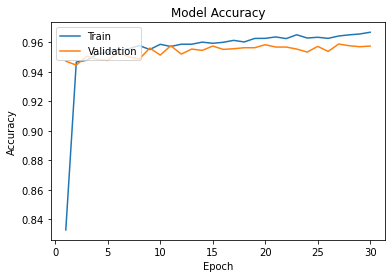

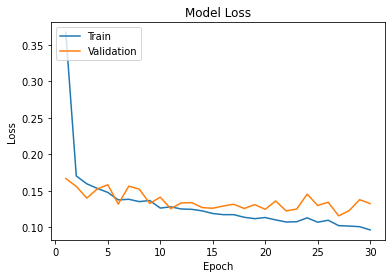

In [95]:
def plotLearningCurve(history,epochs):
    epochRange = range(1,epochs+1)
    plt.plot(epochRange,history.history['accuracy'])
    plt.plot(epochRange,history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

    plt.plot(epochRange,history.history['loss'])
    plt.plot(epochRange,history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()
    
plotLearningCurve(history,(len(history.history['loss'])))

## Result Overview


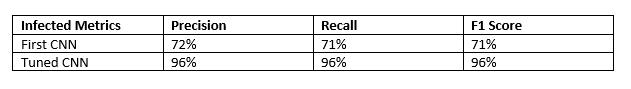

Reviewing the results from hyper-parameters tuned, in cases involving the classification of infected blood smears there were small improvements. However, there is importance to ensuring that patients are correctly diagnosed with their illnesses and treated, as this is the highest requirement for this field of application.



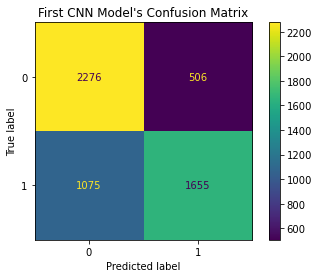

In [96]:
cm = confusion_matrix(y_test, first_preds) # confusion matric for first CNN

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("First CNN Model's Confusion Matrix")
plt.show()

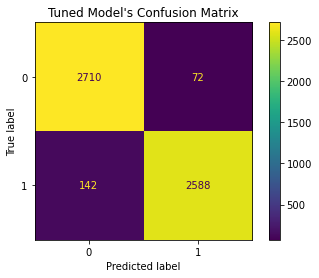

In [97]:
bestcm = confusion_matrix(y_test, bestmodel_preds) # confusion matric for tuned CNN

disp = ConfusionMatrixDisplay(confusion_matrix=bestcm)
disp.plot()
plt.title("Tuned Model's Confusion Matrix")
plt.show()

The tuned model presented a larger number of correctly identified cases of malaria, with a lower number of false positives. For testing purposes, imbalanced testing classifications were used to allow for the reflection of real-world testing, where the tests provided may not be balanced.

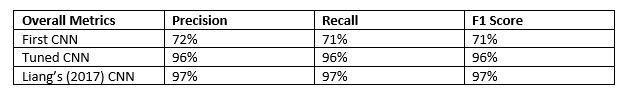

When comparing all the overall metrics of the models together including the results produced by Liang (2017), it is visible that Liang’s model outperforms the tuned model created in this report. Because of this, a look into the data preprocessing and model architecture is required to evaluate what was done differently. It was discussed during Liang’s preprocessing that a 90/10 split in data would be used, compared to the 80/20 used in this report. This could result in 2 things; a better-trained model due to a larger exposure to the dataset, or better results due to a lower testing set. However, the model architecture used by Liang consisted of 6 convolutional layers, with 3 fully connected layers at the end before the sigmoid activation was run. The model used in this report has 4 convolutional layers with a dense layer before the sigmoid activation runs. Each layer in Liang’s system included a greater number of nodes than that of the one developed in this report. This all could result in the improvement Liang’s system shows, as the more complex system may be able to identify patterns in the dataset that this report's model was not able to.

In [98]:
first_y_score = first_model.predict(X_test) # get the prediction probabilities

In [99]:
best_y_score = BestCnnModel.predict(X_test) # get the prediction probabilities

In [100]:
# First CNN model

first_fpr = dict()
first_tpr = dict()
first_roc_auc = dict()

first_fpr, first_tpr, _ = roc_curve(y_test, first_y_score[:, 0])
first_roc_auc = auc(first_fpr, first_tpr)

# Best CNN model

best_fpr = dict()
best_tpr = dict()
best_roc_auc = dict()

best_fpr, best_tpr, _ = roc_curve(y_test, best_y_score[:, 0])
best_roc_auc = auc(best_fpr, best_tpr)

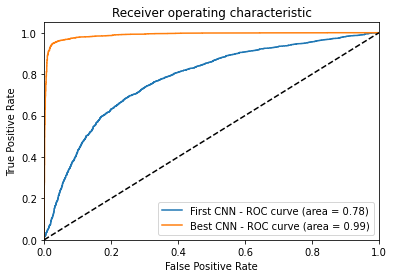

In [101]:
plt.figure()

# First CNN model plot
plt.plot(first_fpr, first_tpr, label='First CNN - ROC curve (area = %0.2f)' % first_roc_auc)


# Best CNN model plot
plt.plot(best_fpr, best_tpr, label='Best CNN - ROC curve (area = %0.2f)' % best_roc_auc)


# Final ROC plot formatting
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Clear output string
print("")

Although this is the case, there is still a promising result shown from the hyperparameter turning utilised in this report. A visible improvement can be seen in both the ROC and PRC curves. This demonstrates that the tuned model is better at discriminating between positive and negative classifications, and provides a better trade-off between precision and recall.

In [102]:
first_precision, first_recall, _ = precision_recall_curve(y_test, first_y_score)

best_precision, best_recall, _ = precision_recall_curve(y_test, best_y_score)

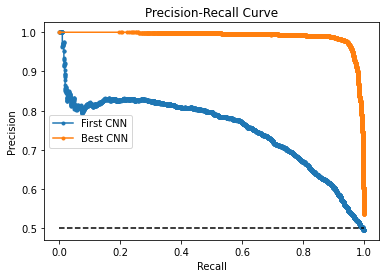

In [103]:
# First CNN model plot

plt.plot(first_recall, first_precision, marker='.', label='First CNN')

# Best CNN model plot

plt.plot(best_recall, best_precision, marker='.', label='Best CNN')


no_skill = len(y[y==1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], 'k--')
plt.title('Precision-Recall Curve')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()


# Clear output string
print("")

# Evaluation

Based on the work performed, it is apparent that the convolutional neural network model is an appropriate solution for blood smear classification. In comparison to the typical machine learning approaches of SVM and random forests, the CNN model performed 1% better overall. The hyper-tuned model was able to perform with an accuracy of 96%, with 95% of infections correctly detected. As a starting point, this is a great metric for the work this solution will be performing, but there are still too many missed positive infections. The work produced by Liang (2017) was able to produce a model with a 1-2% improvement over the metrics used in comparison to the hyper-tuned model.

It is evident from the work produced by Liang (2017) that there are better designs for solving this problem. In the future, working from this architecture or a high-performing design like this may provide a greater starting point in the design, and perhaps through fine-tuning, the model could become even more robust. Another area that could be visited is the impact of the darkened backgrounds around the cell image, and its impact on the classification results of these models. Due to the application of these models being medical diagnosis, it is not only required to be an accurate model, but capable of capturing as many true positive images as possible to ensure that no patient's illness goes undiagnosed and untreated. Alternatively, with greater hardware solutions, a higher resolution of image could have been used during the preprocessing stage, as the lower the res the higher the information loss.

Deep learning should provide a significant improvement to malaria diagnosis if adopted but should also provide a reliable solution for many other health-related applications. Further work that could be done is evaluating deep learning approaches with alternative illnesses, such as cancer detection, pneumonia, and gait detection. This could provide valuable early detection systems that could save lives or provide people with the necessary treatment required.


# References

Challa, S. K., Kumar, A. and Semwal, V. B. (2022) ‘A multibranch CNN-BiLSTM model for human activity recognition using wearable sensor data’, Visual Computer, 38(12), pp. 4095–4109. doi: 10.1007/s00371-021-02283-3.

Chang, C. C. and Lin, C. J. (2011) ‘LIBSVM: A Library for support vector machines’, ACM Transactions on Intelligent Systems and Technology, 2(3). doi: 10.1145/1961189.1961199.

Cook, J. and Ramadas, V. (2020) ‘When to consult precision-recall curves’, Stata Journal, 20(1), pp. 131–148. doi: 10.1177/1536867X20909693.

Doctors Without Borders (2021) Malaria, MSF. Available at: https://msf.org.uk/issues/malaria?gad=1&gclid=Cj0KCQjw27mhBhC9ARIsAIFsETHFVxClZ1OEggubOcFznRf-dh28_Mss3s_m_co5Di6UZNNjQ45vB1kaAsYyEALw_wcB&gclsrc=aw.ds.

Hoo, Z. H., Candlish, J. and Teare, M. D. (2017) ‘What is a ROC curve?’, Emergency Medicine Journal.

Ikerionwu, C. et al. (2022) ‘Application of machine and deep learning algorithms in optical microscopic detection of Plasmodium: A malaria diagnostic tool for the future’, Photodiagnosis and Photodynamic Therapy. Elsevier B.V., 40(November 2022), p. 103198. doi: 10.1016/j.pdpdt.2022.103198.

Korotcov, A. et al. (2017) ‘Comparison of Deep Learning with Multiple Machine Learning Methods and Metrics Using Diverse Drug Discovery Data Sets’, Molecular Pharmaceutics, 14(12), pp. 4462–4475. doi: 10.1021/acs.molpharmaceut.7b00578.

Liang, Z. et al. (2017) ‘CNN-based image analysis for malaria diagnosis’, Proceedings - 2016 IEEE International Conference on Bioinformatics and Biomedicine, BIBM 2016. IEEE, pp. 493–496. doi: 10.1109/BIBM.2016.7822567.

Prati, R. C., Batista, G. E. A. P. A. and Monard, M. C. (2009) ‘Data mining with unbalanced class distributions: Concepts and methods’, in Proceedings of the 4th Indian International Conference on Artificial Intelligence, IICAI 2009, pp. 359–376.

Rajaraman, S. et al. (2018) ‘Pre-trained convolutional neural networks as feature extractors toward improved malaria parasite detection in thin blood smear images’, PeerJ. PeerJ Inc., 2018(4), p. e4568. doi: 10.7717/PEERJ.4568/SUPP-1.

Thorn, K. (2016) ‘A quick guide to light microscopy in cell biology’, Molecular Biology of the Cell, 27(2), pp. 219–222. doi: 10.1091/mbc.E15-02-0088.

WHO (2016) ‘Malaria microscopy quality assurance manual – Ver. 2’, World Health Organization, p. 140.

